# Lab 2: Classification

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

In [1]:
%pylab inline
plt.rcParams["figure.figsize"] = [9,5]
import time

Populating the interactive namespace from numpy and matplotlib


In [4]:
#Importing needed libraries
import sys
import platform
from importlib.util import find_spec, module_from_spec

# Part 1. Multiclass logistic regression

The aim of this notebook is to implement methods to return the digit class of an image of a handwritten digit. The dataset used is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`).

In [5]:
from sklearn.datasets import fetch_mldata
import os
# Fetch the data
mnist = fetch_mldata('MNIST original', data_home='.')
data, target = mnist.data, mnist.target.astype('int')
# Shuffle
indices = np.arange(len(data))
np.random.seed(123)
np.random.shuffle(indices)
data, target = data[indices].astype('float32'), target[indices]

# Normalize the data between 0.0 and 1.0:
data /= 255.

# Split
x_train, x_valid, x_test = data[:50000], data[50000:60000], data[60000: 70000]
t_train, t_valid, t_test = target[:50000], target[50000:60000], target[60000: 70000]

MNIST consists of small 28 by 28 pixel images of written digits (0-9). The dataset is split into a training, validation and testing arrays. The variables `x_train`, `x_valid` and `x_test` are $N \times M$ matrices, where $N$ is the number of datapoints in the respective set, and $M = 28^2 = 784$ is the dimensionality of the data. The second set of variables `t_train`, `t_valid` and `t_test` contain the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

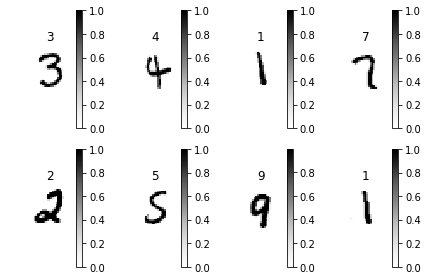

In [6]:
def plot_digits(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_digits(x_train[0:40000:5000], num_cols=4, targets=t_train[0:40000:5000])

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class.

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_i \exp(\log q_i)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

When computing $\log Z$, the [log-sum-exp trick](https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/ "Title") is used

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## Gradient-based stochastic optimization
### Derive gradient equations

To be able to implement gradient-based stochastic optimization, the gradient equations need to be derived. Therefore, the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$ are derived.

First, the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$ are derived. The shorthand notation $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ is used.

For $j = t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z}
\frac{\partial Z}{\partial \log q_j}
= 1
-
\frac{\partial \log Z}{\partial Z}
\frac{\partial Z}{\partial \log q_j}
= 1 - \dfrac{q_j}{Z}
$$

For $j \neq t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z}
\frac{\partial Z}{\partial \log q_j}
=0 - \frac{\partial \log Z}{\partial Z}
\frac{\partial Z}{\partial \log q_j}
=0 - \dfrac{q_j}{Z}
$$

Here, the following steps are used:

$\frac{\partial \log Z}{\partial Z} = \dfrac{1}{Z}$

$\frac{\partial Z}{\partial \log q_j} = \frac{\partial \sum_i exp(log(q_i))}{\partial \log q_j} = exp(log(q_j)) = q_j$

$\frac{\partial \log Z}{\partial Z} \frac{\partial Z}{\partial \log q_j} = \dfrac{q_j}{Z}$


Next, the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$ are derived. 

The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is:

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
= \dfrac{\partial( w_j^T \cdot x + b)}{\partial W_{ij}} 
= x_i
$



### Implement gradient computations

The gradient calculation derived are implementend in the function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).


The computation contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).

In [7]:
def logreg_gradient(x, t, w, b):
    x = x.reshape(1, -1)
    logq = x @ w + b
    logq = logq.reshape(1, -1)
    a = np.max(logq)
    logZ = a + log(np.sum(np.exp(logq - a)))
    logp = logq - logZ
    tn = np.zeros_like(logq).reshape(1, -1)
    tn[0, t] = 1
    dq = tn - np.exp(logq-logZ)
    dL_dw = x.T @ dq
    dL_db = dq
    return logp[:,t].squeeze(), dL_dw, dL_db.squeeze()

In [8]:
#The gradient implementation is checked with finite difference checking
from scipy.optimize import check_grad

np.random.seed(123)
w = np.random.normal(size=(28*28,10), scale=0.001)
b = np.zeros((10,))

def func(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return logpt
def grad(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return grad_w.flatten()
finite_diff_error = check_grad(func, grad, w.flatten())
print('Finite difference error grad_w:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for w seems off'

def func(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return logpt
def grad(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return grad_b.flatten()
finite_diff_error = check_grad(func, grad, b)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'



Finite difference error grad_w: 6.36129468949e-07
Finite difference error grad_b: 5.23511748692e-08



### Stochastic gradient descent

The gradient function can next be used to implement stochastic gradient descent. The function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights, is implemented. It goes through the trainingset once in randomized order, calls `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and updates the parameters **using a small learning rate of `1e-4`**.

In [9]:
def sgd_iter(x_train, t_train, W, b):
    r = np.array(range(len(t_train)))
    np.random.shuffle(r)
    x = x_train[r]
    t = t_train[r]
    lr = 1e-4
    logp_train = 0
    for i in range(len(t)):
        logp, grad_w, grad_b = logreg_gradient(x[i, :], t[i], W, b)
        logp_train += logp
        W += lr*grad_w
        b -= lr*grad_b
    return logp_train, W, b

## Train

### Train
Next, SGD is performed on the training set. THe conditional log-probability of the training and validation set after each iteration are plotted. SGD is run until convergence and the implementation is independent of the size of the dataset. 


In [10]:

def test_sgd(x_train, t_train, x_valid, t_valid, w, b):
    avg_logp_train = -10
    diff_p = 1
    old_p = 0
    i = 0
    trainps = []
    valps= []
    while diff_p > 5e-3:
        logp_train, w, b = sgd_iter(x_train, t_train, w, b)
        avg_logp_train = np.sum(logp_train)/len(t_train)
        diff_p = np.exp(avg_logp_train) - old_p
        old_p = np.exp(avg_logp_train)
        trainps.append(avg_logp_train)

        logq_val = x_valid @ w + b
        a = np.max(logq_val)
        logZ_val = a + log(np.sum(np.exp(logq_val - a), axis=1)).reshape(logq_val.shape[0], 1)
        logp_val = logq_val - logZ_val
        logp_val = logp_val[np.arange(logp_val.shape[0]), t_valid]
        avg_logp_val = np.sum(logp_val)/len(t_valid)
        valps.append(avg_logp_val)

        print('Epoch', i, '\t train avg p - ', np.exp(avg_logp_train), '\t val avg p = ', np.exp(avg_logp_val))
        i += 1

    plt.plot(range(i), trainps, label='train log prob')
    plt.plot(range(i), valps, label='validation log prob')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('log prob')
    plt.show()
    return w, b

Epoch 0 	 train avg p -  0.295488258974 	 val avg p =  0.448609757776
Epoch 1 	 train avg p -  0.503723675005 	 val avg p =  0.540083880241
Epoch 2 	 train avg p -  0.567509609256 	 val avg p =  0.581757695538
Epoch 3 	 train avg p -  0.600809450844 	 val avg p =  0.606698140053
Epoch 4 	 train avg p -  0.621995670204 	 val avg p =  0.623440371159
Epoch 5 	 train avg p -  0.636954813451 	 val avg p =  0.635799529177
Epoch 6 	 train avg p -  0.648190877829 	 val avg p =  0.645163192797
Epoch 7 	 train avg p -  0.657011955244 	 val avg p =  0.652851344928
Epoch 8 	 train avg p -  0.664207350966 	 val avg p =  0.658944028611
Epoch 9 	 train avg p -  0.670179288488 	 val avg p =  0.664174279568
Epoch 10 	 train avg p -  0.67523438356 	 val avg p =  0.668692979248
Epoch 11 	 train avg p -  0.6796041545 	 val avg p =  0.672440337247


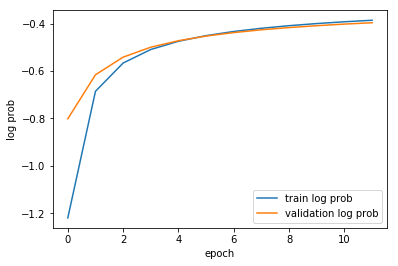

In [25]:
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
w,b = test_sgd(x_train, t_train, x_valid, t_valid, w, b)

### Visualize weights
The resulting parameters $\bW$ after a few iterations through the training set are visualized, by treating each column of $\bW$ as an image. 

From this figure it can be seen that each of the ten weights seems to have converged to a single digit. In other words, when a digit is fed to the classifier only one weight will result in a large outcome when multiplied with the image, and thus the probability for only one class will be high. Therefore, the loss is low.

<function matplotlib.pyplot.show(*args, **kw)>

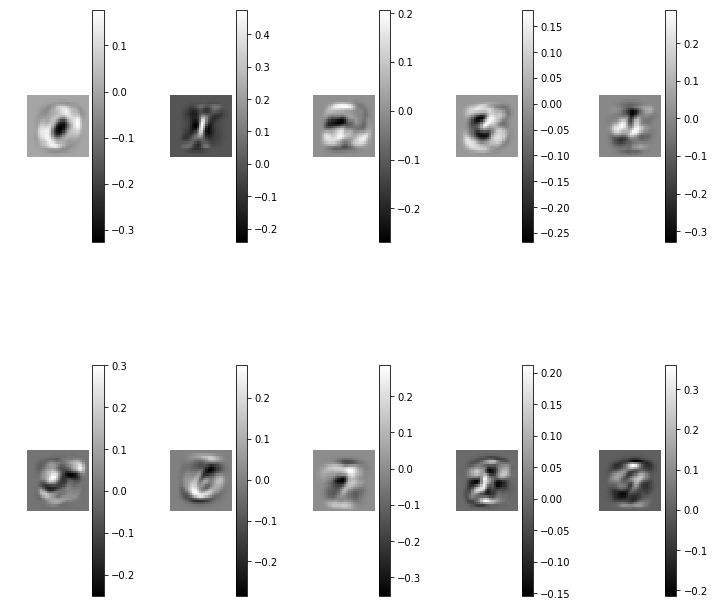

In [27]:
plt.figure(figsize(10, 10))
for i in range(w.shape[1]):
    plt.subplot(2, 5, i+1)
    plt.imshow(w[:, i].reshape(28,28), interpolation="none", cmap='gray')
    plt.colorbar()
    plt.axis('off')
plt.tight_layout()
plt.show


### Visualize the 8 hardest and 8 easiest digits

Finally, the 8 digits in the validation set with the highest probability of the true class label under the model are visualized as well as the 8 digits that were assigned the lowest probability.

The results obtain make sense: the least likely datapoints are at least somewhat ambiguous, i.e. they resemble more than one digit, and the most likely datapoints are very clear, as they could not be anything but a 2.


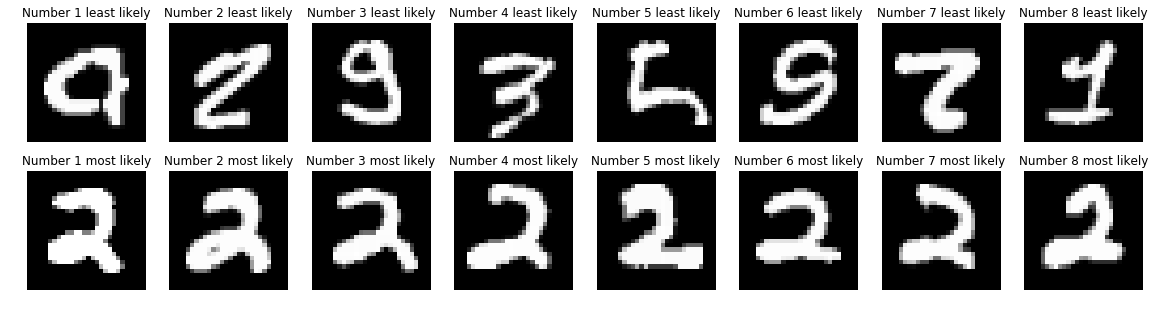

In [28]:
logq_val = x_valid @ w + b
a = np.max(logq_val)
logZ_val = a + log(np.sum(np.exp(logq_val - a), axis=1)).reshape(logq_val.shape[0], 1)
logp_val = logq_val - logZ_val
logp_val = logp_val[np.arange(logp_val.shape[0]), t_valid]
p_val = np.exp(logp_val)
p_idx = np.argsort(p_val)

plt.figure(figsize=(20, 5))
for i in range(8):
    plt.subplot(2, 8, i+1)
    plt.title('Number {0} least likely'.format(i+1))
    plt.imshow(x_valid[p_idx[i], :].reshape(28, 28), cmap='gray')
    plt.axis('off')

    plt.subplot(2, 8, i+9)
    plt.title('Number {0} most likely'.format(i+1))
    plt.imshow(x_valid[p_idx[-(i+1)], :].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()




# Part 2. Multilayer perceptron

Next, a multilayer perceptron (MLP) is implemented. The perceptron will have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$).

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## Derive gradient equations

First, the gradient equations are derived; the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$.

$ \delta_j^q = \frac{\partial \mathcal{L}^n}{\partial log(q_j)} $

for j = $t_n$ this gives: $1 - \frac{1}{Z} \cdot q_j$ 

for j $\neq$ $t_n$ this gives: $0 - \frac{1}{Z} \cdot q_j$ 

$\delta^q$ is a 10 by 1 vector with entries $\delta_j^q$.  

This gives: $\delta^q = e_j - \frac{1}{Z} \cdot q$. Where $e_j$ is a 10 by 1 vector of zeros with 1 on on position j, with j = $t_n$. 

$ \delta_j^h = \frac{\partial \mathcal{L}^n}{\partial h_j} = \left[ \frac{\partial \mathcal{L}^n}{\partial log(q)} \right]^T \cdot \frac{\partial log(q)}{\partial h_j} = (\delta^q)^T \cdot w_j$, where $w_j$ refers to row j of matrix W.

This gives, $\delta^h = W \cdot \delta^q $

$\frac{\mathcal{L}^n}{\partial w_{ji}} = \frac{\mathcal{L}^n}{\partial log(q_j)} \cdot \frac{\partial log(q_j)}{ \partial w_{ji}} = \delta_j^q \cdot h_i $

This gives, $\frac{\partial \mathcal{L}^n}{\partial W} = h \cdot (\delta^q)^T $

$ \frac{\partial \mathcal{L}^n}{\partial b_j} = \frac{\partial \mathcal{L}^n}{\partial log(q_j)} \cdot \frac{\partial log(q_j)}{\partial b_j} = \delta_j^q \cdot 1  $

This gives $\frac{\partial \mathcal{L}^n}{\partial b} = \delta^q $

$\frac{\mathcal{L}^n}{\partial v_{ji}} = \frac{\mathcal{L}^n}{\partial h_j} \cdot \frac{\partial h_j}{ \partial v_{ji}} = \delta_j^h \cdot h_j \cdot (1 - h_j) \cdot x^n_i $

This gives $ \frac{\partial \mathcal{L}^n}{\partial V} = x^n \cdot [\delta^h * h * (1-h)]^T$, where '*' refers to element wise multiplication and '.' to the dot product.

$ \frac{\partial \mathcal{L}^n}{\partial a_j} = \frac{\partial \mathcal{L}^n}{\partial h_j} \cdot \frac{\partial h_j}{\partial a_j} = \delta_j^h \cdot h_j \cdot (1 - h_j)  $

This gives $\frac{\partial \mathcal{L}^n}{\partial a} = \delta^h * h * (1-h) $, where '*' refers to element wise multiplication

The derivative wrt b is the same as in the multiclass logistic regression case as the relationship between b and the log Likelihood is the same. The differences in models occurs in the previous layer, where the sigmoid function is implemented. The derivative wrt W is therefore different from the earlier case, as w is now multiplied with the outcome of the sigmoid function instead of x directly (as was the case previoulsy: $\log q_j = \bw_j^T \bx + b_j$)


## 2.3. Implement and train a MLP (15 points)

An MLP model is implemented, with a single hidden layer of **20 neurons**. 
The model is trained for **10 epochs**.
The implementation is tested for learning rates of 1e-2, 1e-3 and 1e-4 and the conditional log-probability of the trainingset and validation set are plotted.

The figure shows that the higher the learning rate, the bigger the steps are in the Stochastic Gradient Descent, resulting in a larger update in the weights (for a given gradient) and thus fast convergence. This is clearly shown by the average loglikelihood being closer to zero for higher learning rates, already after the first iteration. Whilst the graphs for 0.01 and 0.001 become approximately flat after iteration 3, 0.0001 has still not converged after 10 iterations.



In [29]:
#All the helper functions
def sigmoid(x):
    y = 1 / (1 + exp(-x))
    return y

def initialize(M, L, classes):
    V = np.zeros((M,L))
    W = np.random.rand(L, classes)
    a = np.random.rand(L, 1)
    b = np.random.rand(classes, 1)
    return V, W, a, b

def forward_prop(x, t, V, W, a, b):    
    c = np.dot(V.T, x) + a  
    h = sigmoid(c) 
    log_q = np.dot(W.T, h) + b    
    a_max = np.max(log_q)   
    log_Z = a_max + np.log(sum(exp(log_q - a_max)))    
    q = exp(log_q)
    Z = exp(log_Z)
    log_p = log_q[t] - log_Z  
    return c, h, log_q, q, Z, log_Z, log_p
 
def backward_prop(V, W, a, b, t, q, Z, h, lr):
    vect = np.zeros(10).reshape(10,1)
    np.put(vect, t, 1)    
    delta_q = vect - 1 / Z * q
    delta_h = np.dot(W, delta_q)
    der_W = np.dot(h, delta_q.T)
    der_b = delta_q
    der_V = np.dot(x, (np.dot(W, delta_q) * h * (1-h)).T)
    der_a = delta_h * h * (1-h)
    W += lr * der_W
    b += lr * der_b
    V += lr * der_V
    a += lr * der_a
    return V, W, a, b

def log_lik(x, T, V, W, a, b):    
    N = x.shape[0]
    A = np.dot(x, V) + a.T
    H = sigmoid(A)
    log_Q = np.dot(H, W)
    
    a_max = np.max(log_Q, axis = 1).reshape(N, 1)
    log_Z = a_max + np.log(exp(log_Q - a_max).sum(axis=1)).reshape(N,1)  

    log_L = log_Q - log_Z

    L_matrix = T * (log_L)
    logLik_vect = L_matrix.sum(axis=1)
    logLik = np.sum(logLik_vect)

    return logLik

In [32]:
#Use a set of learning rates
learning_rates = [0.01, 0.001, 0.0001]
learning_rates = [0.0001, 0.001, 0.01]
train = [0,0,0]
valid = [0,0,0]

#Set of initial variables used
M = x_train.shape[1]
L = 20
classes = 10
N = x_train.shape[0]
epochs = range(1,11)
loop = np.arange(0, N, 1)

#Creating a matrix for T with a 1 in the place of the correct digit and zero elsewhere
#This is used to calculated the likelihood of a whole dataset without having to loop
T_train = np.zeros((t_train.shape[0], 10))
for i in range(t_train.shape[0]):
    T_train[i, t_train[i]] = 1

T_valid = np.zeros((t_valid.shape[0], 10))
for i in range(t_valid.shape[0]):
    T_valid[i, t_valid[i]] = 1

In [33]:
for lr in learning_rates:   
    #Initialize the variables
    V, W, a, b = initialize(M, L, classes)
    logLik_train = []
    logLik_valid = []

    #Perform 10 epochs
    for j in epochs:       
        #Create a random order of X to loop through for SGD
        random.shuffle(loop)

        #Apply SGD, 1 epoch is when every data point in the training set has been seen once   
        for i in loop:        
            x = x_train[i, :].reshape(M, 1)
            t = t_train[i]        
            c, h, log_q, q, Z, log_Z, log_p = forward_prop(x, t, V, W, a, b)
            V, W, a, b = backward_prop(V, W, a, b, t, q, Z, h, lr)

        #After every epoch, calculate the average log Likelihood for the train and validation set
        p_train = log_lik(x_train, T_train, V, W, a, b)
        p_valid = log_lik(x_valid, T_valid, V, W, a, b)

        #Add these to a list
        logLik_train.append(p_train / x_train.shape[0])
        logLik_valid.append(p_valid / x_valid.shape[0])

    #Save the found average log Likelihoods for the train and validation set for each learning rate
    index = learning_rates.index(lr)
    train[index] = logLik_train
    valid[index] = logLik_valid

    #Save the weights of the best model  to visualize
    if lr == 0.01:
        weights = V

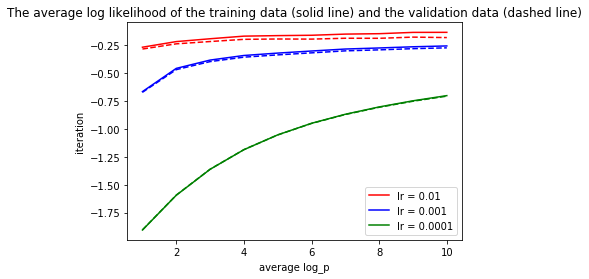

In [9]:
# plot the train and validation logp for all three learning rates in one figure
epoch = range(1,11)

plt.plot(epoch, train[0], label = 'lr = 0.01', color='red')
plt.plot(epoch, train[1], label = 'lr = 0.001', color='blue')
plt.plot(epoch, train[2], label = 'lr = 0.0001', color='green')

plt.plot(epoch, valid[0], linestyle='dashed', color='red')
plt.plot(epoch, valid[1], linestyle='dashed', color='blue')
plt.plot(epoch, valid[2], linestyle='dashed', color='green')

plt.legend()
plt.ylabel('average log_p')
plt.xlabel('iteration')
plt.title('The average log likelihood of the training data (solid line) and the validation data (dashed line)')

plt.figure(figsize=(30,1))

### Explain the weights

As shown in the figure, the learning rate of 0.01 provides the best result. For this model, the weights of the first layer are saved and displayed below. 

When comparing the plot with that of the logistic regression, it can be seen that it is a lot more abstract whilst in each weight plot of the logistic regression you can almost identify a number. This is because  the weights in logistic regression directly relate the x to log q, whilst in the MLP, there first is a non-linear transformation followed by another set of weights(W). This makes the MLP model more flexible, thereby resulting in a better performance

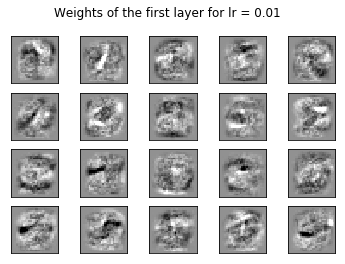

In [10]:
V = weights
fig, axes = plt.subplots(4, 5)

v_min, v_max = V.min(), V.max()
for coef, axis in zip(V.T, axes.ravel()):
    axis.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=0.5 * v_min,
               vmax=0.5 * v_max)
    axis.set_xticks(())
    axis.set_yticks(())

fig.suptitle('Weights of the first layer for lr = 0.01')
plt.show()

### Different activation functions
In the task above a sigmoid function is used as an activation function.

Two properties that you would like your activation function to have are:

1. Would like the activation function to be smooth (continuously differentiable) 
2. Want it to be non-linear

This is because when performing backpropogation, the derivative of the activation function is used. Thus, having a smooth activation function ensures that at every point, it is possible to obtain this derivative. We want the activation function to be non-linear, as a linear activation function has a constant gradient. As a consequence, whenever backpropogation is performed, the gradient would be constant as it does not depend on the input values. 

Two other popular choices for activation functions are tanh and the rectified linear unit (ReLU). 

ReLu: f(x) = max(0,x)

f'(x) = 0 when $x < 0$\n

f'(x) = 1 when $x > 0$

f'(x) is undefined when x = 0 (but in practice often set to 0)

tanh: f(x) = $\frac{e^x - e^{-x}}{e^x + e^{-x}}$

f'(x) = 1 - $(f(x))^2$
The derivatives for these activation function are derived and for all three activation functions, their functions and derivatives are plotted in a range $x\in[-3,3]$

These figure show that the sigmoid function meets the two properties mentioned above.

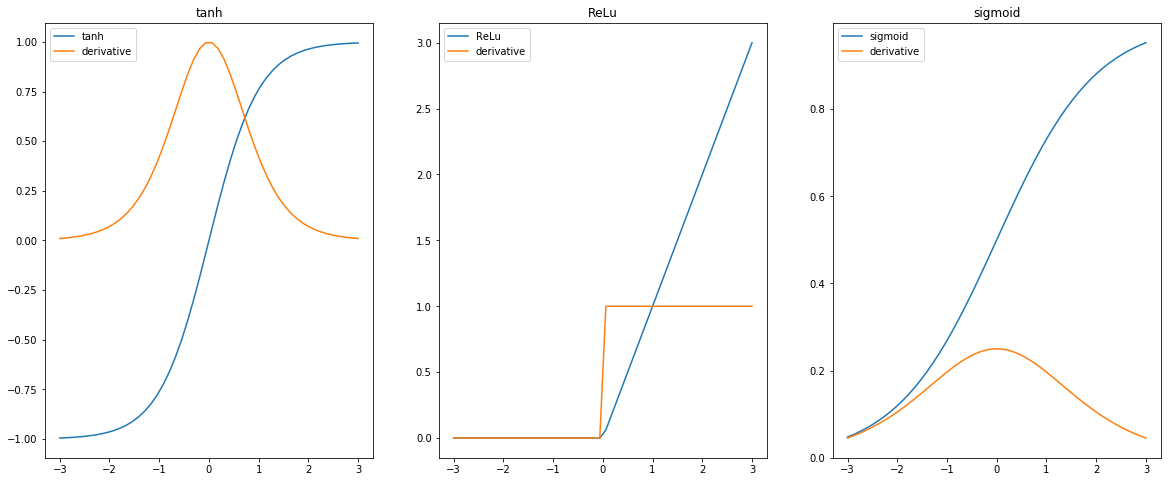

In [36]:
N = 50
x = np.linspace(-3, 3, N)

tanh = (exp(x) - exp(-x)) / (exp(x) + exp(-x))
ReLu = np.maximum(np.zeros(N), x)
sigmoid = 1 / (1 + exp(-x))

tanh_der = np.ones(N) - ((exp(x) - exp(-x)) / (exp(x) + exp(-x)))**2
ReLu_der = [1 if x[i] > 0 else 0 for i in range(N)]
sigmoid_der = (1 / (1 + exp(x))) * (1 - (1 / (1 + exp(x))))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,8))

axes[0].plot(x, tanh, label='tanh')
axes[0].plot(x, tanh_der, label ='derivative')
axes[0].legend()
axes[0].set_title('tanh')

axes[1].plot(x, ReLu, label='ReLu')
axes[1].plot(x, ReLu_der, label='derivative')
axes[1].legend()
axes[1].set_title('ReLu')

axes[2].plot(x, sigmoid, label = 'sigmoid')
axes[2].plot(x, sigmoid_der, label='derivative')
axes[2].legend()
axes[2].set_title('sigmoid')

